In [12]:
import numpy as np
import torch
import yaml
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#parent_dir = os.path.abspath(os.path.join(os.path.dirname('test'), '..'))
#sys.path.append(parent_dir)
from modelComp.UNet import UNet2D

from dataloaders.FullLoaderBubbleML import FullLoaderBubbleML, get_dataloader, get_datasets
%cd
%cd Documents/2024-II/AutoregressiveNeuralOperators/

def load_config(path):
    with open(path) as file:
        config = yaml.safe_load(file)
    return config

C:\Users\tphar
C:\Users\tphar\Documents\2024-II\AutoregressiveNeuralOperators


In [13]:
config = load_config("conf\example.yaml")
train_files = [config['data_path'] + file for file in config['training']['files']]
#train_files = ['../' + file for file in train_files]
val_files = [config['data_path'] + file for file in config['validation']['files']]
#val_files = ['../' + file for file in val_files]
train_dataset, val_dataset = get_datasets(train_files, val_files, discard_first=20, norm=True)

train_loader = get_dataloader(train_dataset, batch_size=4, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=1, shuffle=False)
tw = config['tw']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_file = [r'data\PoolBoiling-SubCooled-FC72-2D\Twall-79.hdf5']
val_file = [r'data\PoolBoiling-SubCooled-FC72-2D\downsampled_redimensionalized\Twall-103.hdf5']
data_OG, data_OG2 = get_datasets(train_file, val_file, discard_first=20, norm=False)
data_OG.__getitem__(0).shape

torch.Size([181, 3, 384, 384])

0
40
80
120


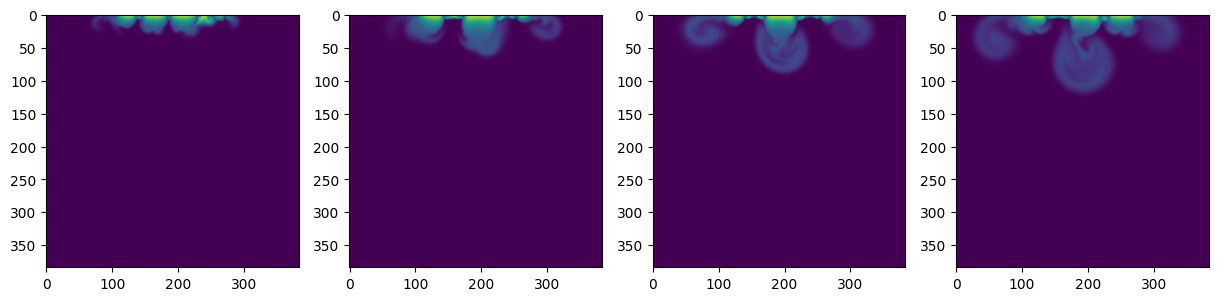

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))
for i in range(4):
    select = i * 40
    ax[i].imshow(data_OG.__getitem__(0)[select, 0, :, :])
    print(select)


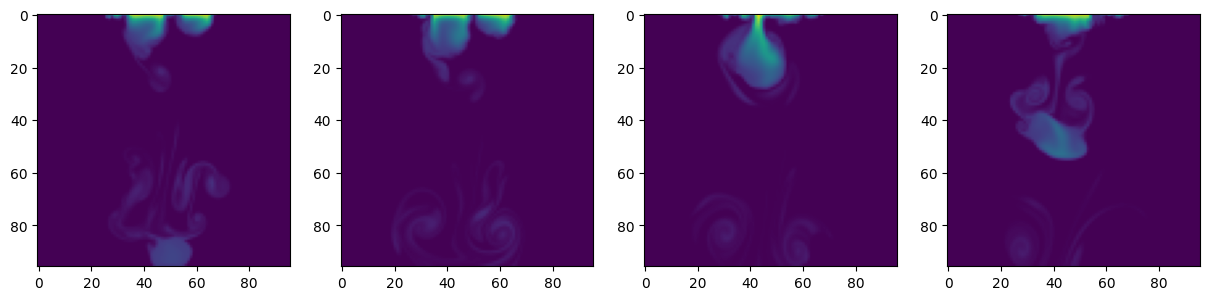

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))
for i in range(4):
    select = i * 4
    ax[i].imshow(data_OG2.__getitem__(0)[select, 0, :, :])

torch.Size([1, 181, 3, 96, 96])
0
4
8
12
16


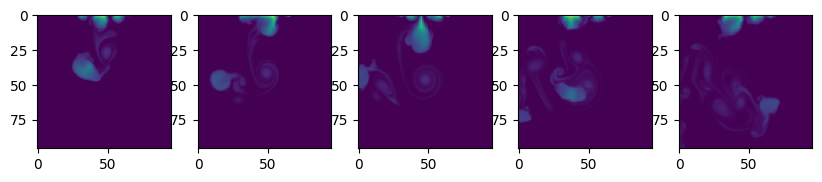

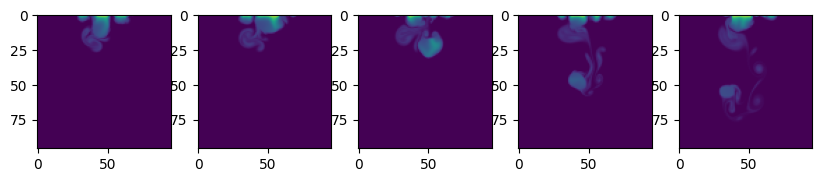

In [16]:
# Plot some data of the validation dataset
for data in val_loader:
    print(data.shape)
    break
fix, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    select = i * 4
    ax[i].imshow(data[0, select, 0, :, :].numpy())
    print(select)
for data in train_loader:
    break
fix, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    select = i * 4
    ax[i].imshow(data[0, select, 0, :, :].numpy())

In [17]:
for raw_data in val_loader:
    break
raw_data.shape
input = raw_data[0, :tw, :, :, :]
input = input.reshape(-1, input.shape[2], input.shape[3])
input = input.unsqueeze(0)
input = input.to(device)
input.shape

torch.Size([1, 15, 96, 96])

In [18]:
model = UNet2D(in_channels=tw * 3, out_channels=tw * 3).to(device)
%cd Documents/2024-II/AutoregressiveNeuralOperators/
model.load_state_dict(torch.load(r'models\best_val_loss_unrolled_UNet3D_DS2015_E70.pth'))

[WinError 3] The system cannot find the path specified: 'Documents/2024-II/AutoregressiveNeuralOperators/'
C:\Users\tphar\Documents\2024-II\AutoregressiveNeuralOperators


C:\Users\tphar\AppData\Local\Temp\ipykernel_3024\578868827.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'models\best_val_loss_unroll

<All keys matched successfully>

In [ ]:
def rollout_temp(model, input, device, steps=180):
    model.eval()
    print(input.shape)
    stacked_pred = input.permute(0,2,1,3)[0, :tw, :, :]  
    with torch.no_grad():
        while stacked_pred.shape[0] < steps:
            output = model(input)
            # stack the output on stacked_pred but take only every first 5 frames
            #print(output.shape)
            print(output)
            stacked_pred = torch.cat((stacked_pred, output.permute(0,2,1,3)[0, :tw, :, :]), 0)
            #stacked_pred = torch.cat((stacked_pred, output), 0)
            input = output
    return stacked_pred
rollout_data = rollout_temp(model, input, device, 180)
raw_data_temp = raw_data[:, :, 0, :, :]
raw_data_temp = raw_data_temp.squeeze(0)
rollout_data.shape, raw_data_temp.shape
# reverse the second dimension with flipud

(torch.Size([180, 15, 96]), torch.Size([181, 96, 96]))

In [23]:
def create_gif3(stacked_true, stacked_pred, output_path):
    timesteps = stacked_pred.shape[0]
    imgtrue_stacked = torch.flip(stacked_true, dims=[1])
    imgpred_stacked = torch.flip(stacked_pred, dims=[1])
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    def update_frame(i):
        ax[0].clear()
        ax[1].clear()

        imgtrue = imgtrue_stacked[i, :, :]
        imgpred = imgpred_stacked[i, :, :]

        ax[0].imshow(imgtrue, cmap='jet', vmin=-1, vmax=1)
        ax[0].set_title("True")
        ax[0].axis('off')

        ax[1].imshow(imgpred, cmap='jet', vmin=-1, vmax=1)
        ax[1].set_title("Prediction")
        ax[1].axis('off')

        fig.suptitle(f"Step {i + 1}/{timesteps}")

    ani = animation.FuncAnimation(fig, update_frame, frames=timesteps, interval=500)
    ani.save(output_path, writer='ffmpeg', fps=10)
    plt.close()

create_gif3(raw_data_temp, rollout_data.cpu(), 'output/rollout_data.gif')